<a href="https://colab.research.google.com/github/camulro/Aprendizaje-I-new/blob/main/07_PCA_credit_scoring_dataset_Bokeh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PCA en dataset de credit scoring con visualización con librería Bokeh**

#### Manuel Sánchez-Montañés

In [1]:
COLAB = True

First we import the libraries we will need. In addition we will use the first code cell to activate the *inline* mode for the graphics generated by *matplotlib*. We also initialize the seed of the random generator.

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## **Data Load**

Now we load the database:

In [3]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1LRagJb0IJPIR9evKpU5v5rpBhKbAxAQw',
                                        dest_path="./datasets/credit_scoring.csv")
    gdd.download_file_from_google_drive(file_id='1KLLKiw0qVFLVYtjZzdE5sijtdv5p9DJ6',
                                        dest_path="./datasets/credit_scoring_Data_Dictionary.xls")


data = pd.read_csv('./datasets/credit_scoring.csv', delimiter=',', header=0)
data.drop(data.columns[0], axis='columns', # quitamos la primera columna
          inplace=True) 

class_column = 'SeriousDlqin2yrs'
classes_names = data[class_column].unique()

print('\033[1m' + 'Credit scoring database\n', '\033[0m')
print('Number of real classes: %d' % len(classes_names))
print('Unique class labels:', classes_names, '\n')
print('\033[1m' + 'First 5 instances:' + '\033[0m')
data.head()

Credit scoring database
 
Number of real classes: 2
Unique class labels: [1 0] 

First 5 instances:


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


El target es Serious...

## **Data Description**

In [5]:
description = pd.read_excel('./datasets/credit_scoring_Data_Dictionary.xls',
                            header=1)
pd.set_option('display.max_colwidth', 200)
description

,Variable Name,Description,Type
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquency or worse,Y/N
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits,percentage
2,age,Age of borrower in years,integer
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.,integer
4,DebtRatio,"Monthly debt payments, alimony,living costs divided by monthy gross income",percentage
5,MonthlyIncome,Monthly income,real
6,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards),integer
7,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or more past due.,integer
8,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans including home equity lines of credit,integer
9,NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days past due but no worse in the last 2 years.,integer


## **Data Exploration**

In [4]:
type(data)

pandas.core.frame.DataFrame

In [6]:
data.describe().T[["count", "min", "max", "mean", "std"]]

,count,min,max,mean,std
SeriousDlqin2yrs,150000.0,0.0,1.0,0.066840,0.249746
RevolvingUtilizationOfUnsecuredLines,150000.0,0.0,50708.0,6.048438,249.755371
age,150000.0,0.0,109.0,52.295207,14.771866
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.0,98.0,0.421033,4.192781
DebtRatio,150000.0,0.0,329664.0,353.005076,2037.818523
MonthlyIncome,120269.0,0.0,3008750.0,6670.221237,14384.674215
NumberOfOpenCreditLinesAndLoans,150000.0,0.0,58.0,8.452760,5.145951
NumberOfTimes90DaysLate,150000.0,0.0,98.0,0.265973,4.169304
NumberRealEstateLoansOrLines,150000.0,0.0,54.0,1.018240,1.129771
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.0,98.0,0.240387,4.155179


### **Outliers**

In [7]:
# los 96 y 98 parece que están indicando NaNs:

aux = ["NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTime60-89DaysPastDueNotWorse", "NumberOfTimes90DaysLate"]

for a in aux:
    print(data[a].unique())

[ 2  0  1  3  4  5  7 10  6 98 12  8  9 96 13 11]
[ 0  1  2  5  3 98  4  6  7  8 96 11  9]
[ 0  1  3  2  5  4 98 10  9  6  7  8 15 96 11 13 14 17 12]


In [8]:
# pongo esos valores a NaN:

for a in aux:
    data[a][data[a]>=96] = np.NaN

In [9]:
# por otra parte elimino del dataset menores de edad (??) y mayores de 80:

data = data[(data["age"]>=18) & (data["age"]<=80)]

### **Missing values**

In [10]:
data.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse      269
DebtRatio                                   0
MonthlyIncome                           27903
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                   269
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse      269
NumberOfDependents                       3385
dtype: int64

In [11]:
clean_data = data.copy()
clean_data.dropna(axis=0, inplace=True)
clean_data.isnull().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

In [12]:
attribute_names = list(clean_data.columns)
attribute_names.remove(class_column)

print(class_column)
print(classes_names)
print(attribute_names)

SeriousDlqin2yrs
[1 0]
['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']


### **Statistics**

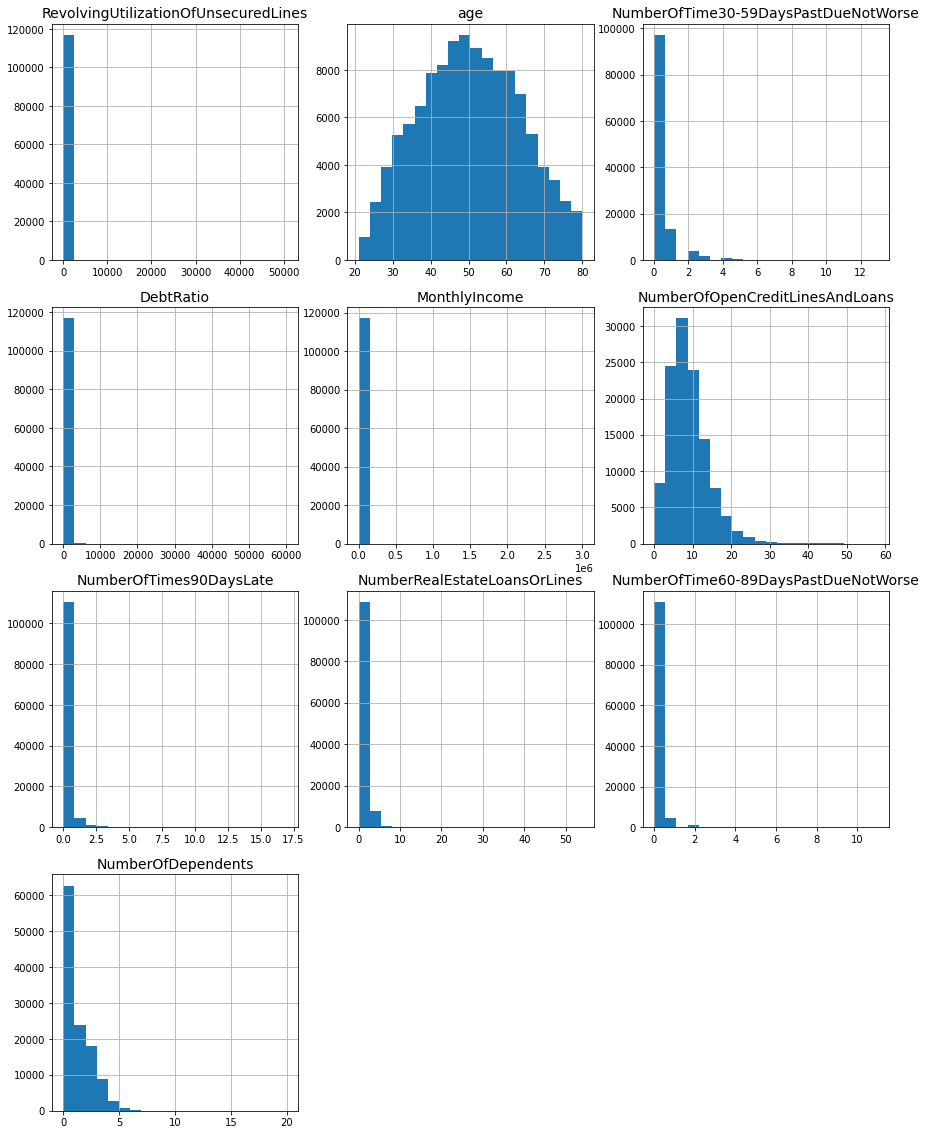

In [13]:
nrows = int(np.ceil(len(attribute_names) / 3))
plt.figure(figsize=(15,5*nrows))
for i in range(len(attribute_names)):
    name = attribute_names[i]
    plt.subplot(nrows,3,i+1)
    clean_data[name].hist(bins=20)
    plt.title(name, fontsize=14)

### Transformo logarítmicamente algunas variables:

In [14]:
clean_data["MonthlyIncome"] = np.log(1+clean_data["MonthlyIncome"])
clean_data["DebtRatio"] = np.log(1+clean_data["DebtRatio"])

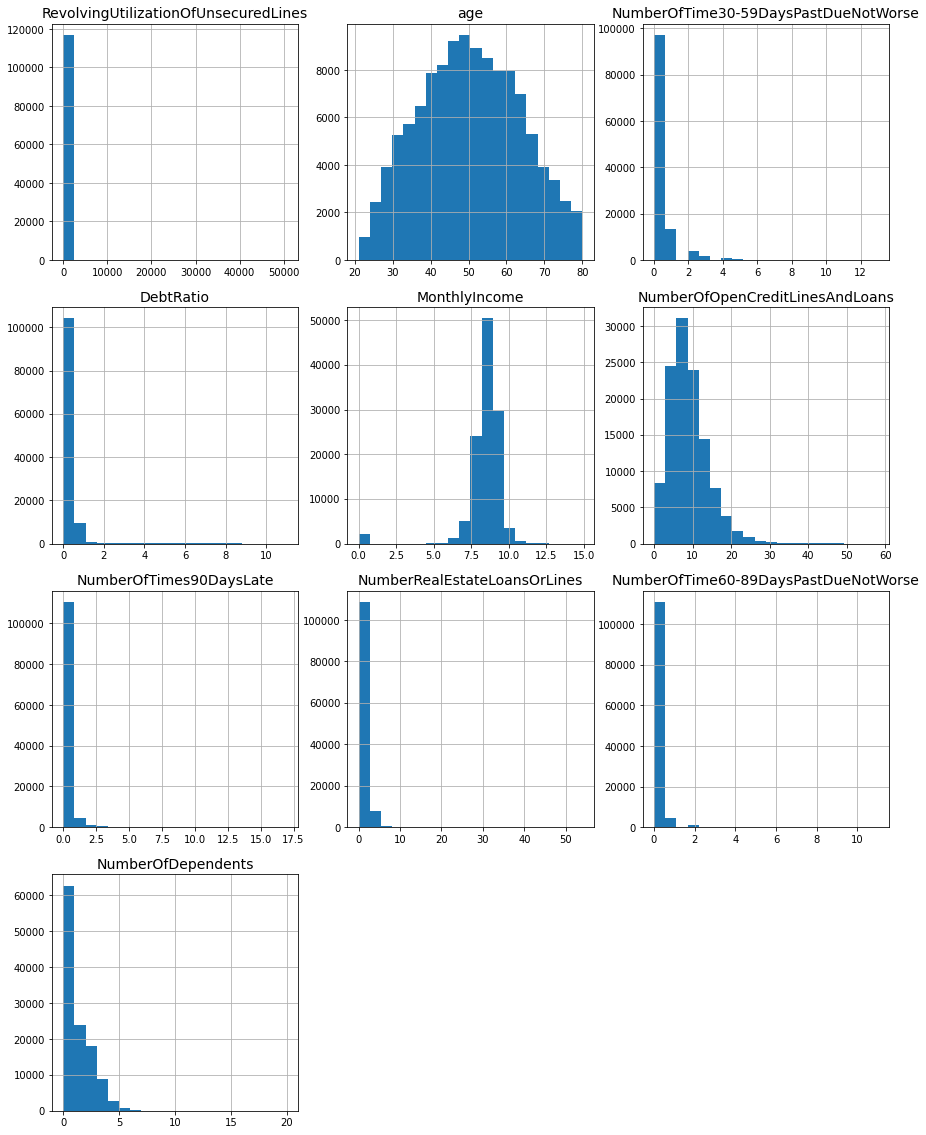

In [15]:
nrows = int(np.ceil(len(attribute_names) / 3))
plt.figure(figsize=(15,5*nrows))
for i in range(len(attribute_names)):
    name = attribute_names[i]
    plt.subplot(nrows,3,i+1)
    clean_data[name].hist(bins=20)
    plt.title(name, fontsize=14)

In [20]:
attribute_names

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']

In [17]:
class_column

'SeriousDlqin2yrs'

In [18]:
X = clean_data[attribute_names].values
y = clean_data[class_column].values

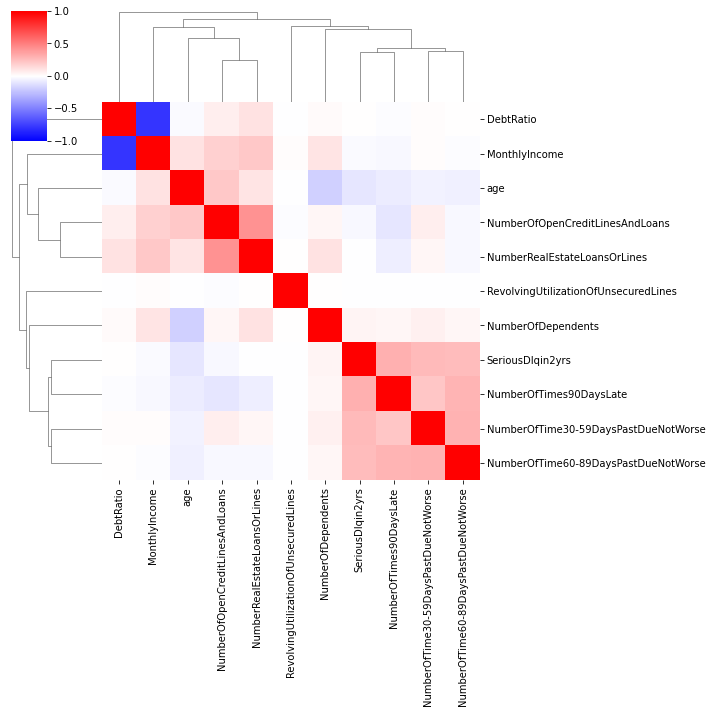

In [19]:
sns.clustermap(clean_data.corr(), cmap="bwr", vmin=-1, vmax=1);

# **PCA**

After loading the database we need to do some basic preprocessing: standarization

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_std = StandardScaler().fit_transform(X)
pca = PCA()
X_pca = pca.fit_transform(X_std)

print()
print('-- Statistics of the data projected on the principal components --')
print()
#pd.DataFrame(X_pca).describe()

for i in range(X_pca.shape[1]):
    print("* Projection in principal component #", i+1, ":")
    print("  - Mean              :", X_pca[:,i].mean().round(3))
    print("  - Variance          :", X_pca[:,i].var(ddof=1).round(3))
    print("  - Eigenvalue        :", pca.explained_variance_[i].round(3))
    print("  - Explained variance:", (100*pca.explained_variance_ratio_[i]).round(3), "%")
    print()

# IMPORTANT: note that we have used all the patterns in the dataset
# to fit the parameters of StandardScaler and PCA
# This is ONLY ok if we are NOT going to develop a predictive model
# for "y" using this data (in that case, we would use both training and test
# data for fitting the parameters, and using test data for fitting is forbidden!)
#
# If we were going to develop a model for predicting the value
# of a target variable "y" (classification / regression problem),
# first we would need to split the dataset in training and test sets:
#
# testsize = 0.2
# Xaux_train, Xaux_test, y_train, y_test = train_test_split(Xaux, y, test_size=testsize)
#
# and both the normalization and PCA should be fitted using only the training set:
#
# std_scaler = StandardScaler()
# std_scaler.fit(Xaux_train)
# X_std_train = std_scaler.transform(Xaux_train)
# pca = PCA(n_components=2)
# pca.fit(X_std_train)
# X_train = pca.transform(X_std_train)
#
# X_std_test = std_scaler.transform(Xaux_test)
# X_test = pca.transform(X_std_test)



-- Statistics of the data projected on the principal components --

* Projection in principal component # 1 :
  - Mean              : 0.0
  - Variance          : 1.878
  - Eigenvalue        : 1.878
  - Explained variance: 18.779 %

* Projection in principal component # 2 :
  - Mean              : -0.0
  - Variance          : 1.611
  - Eigenvalue        : 1.611
  - Explained variance: 16.107 %

* Projection in principal component # 3 :
  - Mean              : -0.0
  - Variance          : 1.498
  - Eigenvalue        : 1.498
  - Explained variance: 14.978 %

* Projection in principal component # 4 :
  - Mean              : 0.0
  - Variance          : 1.153
  - Eigenvalue        : 1.153
  - Explained variance: 11.534 %

* Projection in principal component # 5 :
  - Mean              : -0.0
  - Variance          : 1.0
  - Eigenvalue        : 1.0
  - Explained variance: 9.999 %

* Projection in principal component # 6 :
  - Mean              : -0.0
  - Variance          : 0.772
  - Eigenval

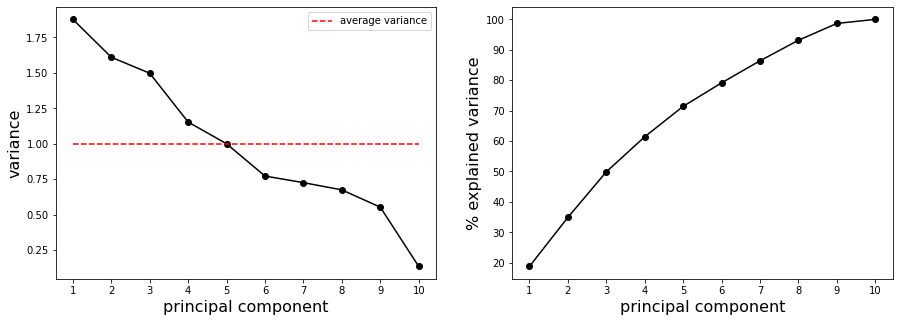

In [22]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(1,pca.n_components_+1), pca.explained_variance_, '-ok')
plt.plot([1,pca.n_components_], [1,1], '--r', label='average variance')
plt.legend()
plt.xlabel('principal component', fontsize=16)
plt.ylabel('variance', fontsize=16)
plt.xticks(range(1,pca.n_components_+1))

plt.subplot(1,2,2)
plt.plot(range(1,pca.n_components_+1),
         100*pca.explained_variance_ratio_.cumsum(), '-ok')
plt.xlabel('principal component', fontsize=16)
plt.ylabel('% explained variance', fontsize=16)
plt.xticks(range(1,pca.n_components_+1));

In [23]:
pcs_names = ['principal component '+str(i+1) for i in range(pca.n_components_)]
pcs_names_short = ['pc '+str(i+1) for i in range(pca.n_components_)]

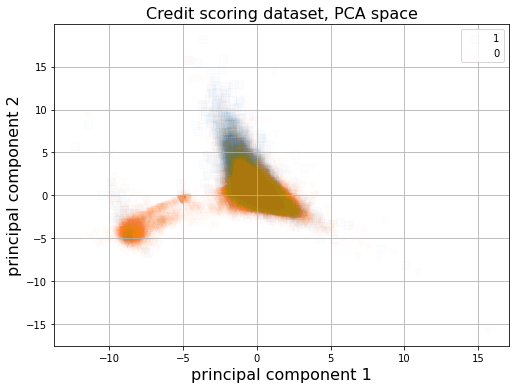

In [24]:
pc_x = 0
pc_y = 1

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ['s', 'v', 'o', 'd', 's', 'v', 'o', 'd', 's']

fig = plt.figure(figsize=(7,5))
for label,color,marker in zip(classes_names,colors,markers):
    inds = np.where(y == label)[0]
    plt.scatter(X_pca[inds, pc_x],
                X_pca[inds, pc_y],
                s = 60,
                c = color,
                marker = marker,
                alpha = 0.01,
                cmap='RdYlGn',
                label = label)

plt.legend(); plt.grid(); plt.tight_layout()
plt.title('Credit scoring dataset, PCA space', fontsize=16)
plt.xlabel(pcs_names[pc_x], fontsize=16)
plt.ylabel(pcs_names[pc_y], fontsize=16);

In [ ]:
def PCA_plot(X_std, y, attribute_names, classes_names,
             colors, markers, pca, pcs_names,
             ax, pc_x=0, pc_y=1, escala_flechas=1, alpha=0.5):
    X_pca = pca.transform(X_std)
    for label,color,marker in zip(classes_names,colors,markers):
        inds = np.where(y == label)[0]
        plt.scatter(X_pca[inds, pc_x],
                    X_pca[inds, pc_y],
                    s = 60,
                    c = color,
                    marker = marker,
                    alpha = alpha,
                    cmap='RdYlGn',
                    label = label)
    factor = escala_flechas*6*np.sqrt(np.max(np.cov(X_std,rowvar=False)))
    aux = np.eye(len(attribute_names))
    attributes_PCA = pca.transform(aux)
    for a,name in zip(attributes_PCA,attribute_names):
        ax.arrow(0, 0, a[pc_x]*factor, a[pc_y]*factor,
                 head_width=1/4*0.05*factor*1.5/escala_flechas,
                 head_length=1/4*0.1*factor*1.5/escala_flechas,
                 fc='k', ec='k')
        plt.text(a[pc_x]*factor, a[pc_y]*factor, name, color='r')
        
    plt.legend(); plt.grid(); plt.tight_layout()
    plt.xlabel(pcs_names[pc_x], fontsize=16)
    plt.ylabel(pcs_names[pc_y], fontsize=16)

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(1,1,1)
PCA_plot(X_std, y, attribute_names, classes_names,
         colors, markers, pca, pcs_names, ax, pc_x=0, pc_y=1,
         escala_flechas=2, alpha=0.01)
plt.title('Credit scoring dataset, PCA coordinates', fontsize=16)
plt.axis('equal');

In [ ]:
nrows = int(np.ceil(pca.n_components_/3))
plt.figure(figsize=(12,4*nrows))
for i in range(pca.n_components_):
    plt.subplot(nrows,3,i+1)
    plt.hist(X_pca[:,i], bins=20)
    plt.title(pcs_names[i], fontsize=14)

In [ ]:
plt.figure(figsize=(5,5))
df_pca = pd.DataFrame(X_pca, columns=pcs_names_short)
sns.heatmap(df_pca.corr(), cmap="bwr", vmin=-1, vmax=1);

In [ ]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool, LabelSet, ColumnDataSource, Range1d
from bokeh.plotting import figure, show, output_notebook

# we select the principal components we will use for visualization
pc_x = 0
pc_y = 1

Xproj = X_pca[:,[pc_x,pc_y]]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# defining the chart
output_notebook()
p = bp.figure(plot_width=700, plot_height=600, title="Credit scoring dataset, PCA space",
              tools="pan,wheel_zoom,box_zoom,reset,hover,save",
              x_axis_label=pcs_names[pc_x],
              y_axis_label=pcs_names[pc_y],              
              #x_axis_type=None, y_axis_type=None,
              min_border=1)
p.title.text_font_size = '16pt'
p.xaxis.axis_label_text_font_style='normal'
p.xaxis.axis_label_text_font_size='16pt'
p.yaxis.axis_label_text_font_style='normal'
p.yaxis.axis_label_text_font_size='16pt'

p.xgrid.visible = False
p.ygrid.visible = False

for label,color,marker in zip(classes_names,colors,markers):
    inds = np.where(y==label)[0][:5000]
    dictf = {'x':Xproj[inds,0],
             'y':Xproj[inds,1],
             'class':len(inds)*[label],
             'Age':clean_data.iloc[inds]["age"],
             'DebtRatio':clean_data.iloc[inds]["DebtRatio"],
             'ntimes60_89DaysPastDueNotWorse':clean_data.iloc[inds]["NumberOfTime60-89DaysPastDueNotWorse"],
             'ntimes90DaysLate':clean_data.iloc[inds]["NumberOfTimes90DaysLate"],
             'row':inds}
    p.scatter(x='x', y='y', source=ColumnDataSource(dictf), color=color,
              legend='class {}'.format(label))
    hover = p.select(dict(type=HoverTool))
    
    # X_pca viene directamente de X_std que viene de X que a su vez viene de clean_data
    #'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
    #   'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
    #   'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
    #   'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
    #   'NumberOfDependents'
    hover.tooltips={"Clase":"@class",
                    "Edad":"@Age",
                    "DebtRatio":"@DebtRatio",
                    "# times 60-89 DaysPastDueNotWorse":"@ntimes60_89DaysPastDueNotWorse",
                    "# times 90 Days Late":"@ntimes90DaysLate",
                    "row":"@row"}
show(p)